In [2]:
import os
import tarfile
from six.moves import urllib

import matplotlib.pyplot as plt

HOUSING_PATH = os.path.join("datasets", "housing")

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [4]:
housing = load_housing_data()

In [5]:
import numpy as np

In [6]:
housing_with_id = housing.reset_index() #adds an 'index' column

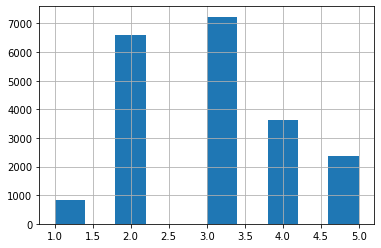

In [7]:
housing["income_cat"] = pd.cut(housing["median_income"],
                              bins=[0., 1.5, 3.0, 4.5, 6., np.inf], #the hell is this
                              labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):                               
    strat_train_set = housing.iloc[train_index]
    strat_test_set = housing.iloc[test_index]

In [9]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [10]:
housing = strat_train_set.drop("median_house_value",axis=1) #creates a copy
housing_labels = strat_train_set["median_house_value"].copy()

In [11]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [13]:
housing_labels.shape

(16512,)

In [11]:
from pandas.plotting import scatter_matrix

In [12]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [13]:
housing_cat=housing[["ocean_proximity"]]

In [14]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):#no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self#nothing to do
    def transform(self, X, y=None): #why is there a y=None
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)#why doesn't True work
housing_extra_attribs = attr_adder.transform(housing.values)

In [16]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

In [18]:
housing_num = housing.drop("ocean_proximity",axis=1)

In [ ]:
#alternative feature extraction transformer and pipeline

In [ ]:
'''from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)
'''

In [ ]:
'''
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features, validate=False)),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
'''

In [19]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [20]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
19480,-120.97,37.66,24.0,2930.0,588.0,1448.0,570.0,3.5395,INLAND
8879,-118.50,34.04,52.0,2233.0,317.0,769.0,277.0,8.3839,<1H OCEAN
13685,-117.24,34.15,26.0,2041.0,293.0,936.0,375.0,6.0000,INLAND
4937,-118.26,33.99,47.0,1865.0,465.0,1916.0,438.0,1.8242,<1H OCEAN
4861,-118.28,34.02,29.0,515.0,229.0,2690.0,217.0,0.4999,<1H OCEAN


In [26]:
housing_prepared.shape

(16512, 16)

In [18]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [19]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [21]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [23]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [70189.97187788 66515.84647562 72070.02653622 69272.57304077
 70260.52661549 74945.82160912 69976.6575075  71261.06230197
 76743.48136779 68913.68508716]
Mean: 71014.96524195214
Standard deviation: 2818.909364798148


In [24]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66755.35819855 66966.14573098 70347.95244419 74769.18698807
 68031.13388938 71229.17716103 64959.86064183 68270.70198961
 71552.91566558 67665.10082067]
Mean: 69054.75335298848
Standard deviation: 2744.2187083829585


In [25]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

/Volumes/lin/MachineLearning/env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [26]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21950.370466403416

In [27]:
#takes a long time to run
scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-scores)
display_scores(forest_rmse_scores)

Scores: [51770.64708571 50042.05003615 51859.0217224  54610.95327632
 51910.79393796 56630.02532556 50838.44459005 49591.29858007
 55279.05196373 53679.30899674]
Mean: 52621.159551468794
Standard deviation: 2214.342725218156


In [30]:
#takes a long time to run
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10 ,30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 7, 8],


In [31]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [32]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [50]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64701.06774320556 {'max_features': 2, 'n_estimators': 3}
55349.823431407705 {'max_features': 2, 'n_estimators': 10}
52885.686276249005 {'max_features': 2, 'n_estimators': 30}
60703.251712263926 {'max_features': 4, 'n_estimators': 3}
53084.496186793316 {'max_features': 4, 'n_estimators': 10}
50525.65787225738 {'max_features': 4, 'n_estimators': 30}
59100.04082674389 {'max_features': 7, 'n_estimators': 3}
52077.96002193393 {'max_features': 7, 'n_estimators': 10}
50222.07859365378 {'max_features': 7, 'n_estimators': 30}
58724.33048912281 {'max_features': 8, 'n_estimators': 3}
52213.742205360984 {'max_features': 8, 'n_estimators': 10}
49788.312235997924 {'max_features': 8, 'n_estimators': 30}
61791.434979489386 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54548.574308619616 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60028.73818993537 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52978.36528047031 {'bootstrap': False, 'max_features': 3, 'n_estimat

In [51]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.28043283e-02, 6.62842207e-02, 4.29214542e-02, 1.51224549e-02,
       1.50414577e-02, 1.44181456e-02, 1.49881066e-02, 3.35341436e-01,
       5.03479897e-02, 1.14084061e-01, 8.24483109e-02, 8.29641459e-03,
       1.62534512e-01, 7.82329177e-05, 1.98868174e-03, 3.30019275e-03])

In [52]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse = True)

[(0.335341435800186, 'median_income'),
 (0.16253451226572285, 'INLAND'),
 (0.11408406134340053, 'pop_per_hhold'),
 (0.08244831089232156, 'bedrooms_per_room'),
 (0.07280432827881068, 'longitude'),
 (0.06628422065005256, 'latitude'),
 (0.05034798968729361, 'rooms_per_hhold'),
 (0.04292145424125698, 'housing_median_age'),
 (0.01512245486593989, 'total_rooms'),
 (0.01504145770859815, 'total_bedrooms'),
 (0.014988106644793562, 'households'),
 (0.014418145622228212, 'population'),
 (0.008296414594064706, '<1H OCEAN'),
 (0.0033001927485221396, 'NEAR OCEAN'),
 (0.0019886817390627125, 'NEAR BAY'),
 (7.823291774587664e-05, 'ISLAND')]

In [53]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)#=> evaluates to 47,730.2

In [56]:
final_rmse

47721.83377630067

In [ ]:
#Exercises

In [ ]:
#Exercise 1

In [72]:
from sklearn.svm import SVR

param_grid = [
    {'kernel': ["linear"], 'C': [2, 4, 6, 8] ,'gamma': [1, 10]},
    {'kernel': ["rbf"], 'C': [1, 2, 3] ,'gamma': [.01 ,.1 ,.3]},
]
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True,
                          verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 17 candidates, totalling 85 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  85 out of  85 | elapsed:  5.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=4,
             param_grid=[{'C': [2, 4, 6, 8], 'gamma': [1, 10],
                          'kernel': ['linear']},
                         {'C': [1, 2, 3], 'gamma': [0.01, 0.1, 0.3],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
from sklearn.svm import SVR

param_grid = [
    {'kernel': ["linear"], 'C': [2, 4, 6, 8] ,'gamma': [1, 10]},
    {'kernel': ["rbf"], 'C': [1, 2, 3] ,'gamma': [.01 ,.1 ,.3]},
]
svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score = True,
                          verbose=2, n_jobs=4)
grid_search.fit(housing_prepared, housing_labels)

In [73]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

87703.58607545428

In [74]:
grid_search.best_params_

{'C': 8, 'gamma': 1, 'kernel': 'linear'}

In [96]:
#Exercise 2

In [97]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# see https://docs.scipy.org/doc/scipy/reference/stats.html
# for `expon()` and `reciprocal()` documentation and 
# more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=3, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)



Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:  7.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='auto_deprecated',
                                 kernel='rbf', max_iter=-1, shrinking=True,
                                 tol=0.001, verbose=False),
                   iid='warn', n_iter=50, n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1390643d0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x138e75c50>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [101]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

55317.01664015225

In [102]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

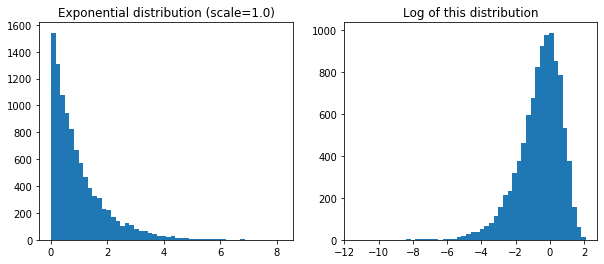

In [103]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

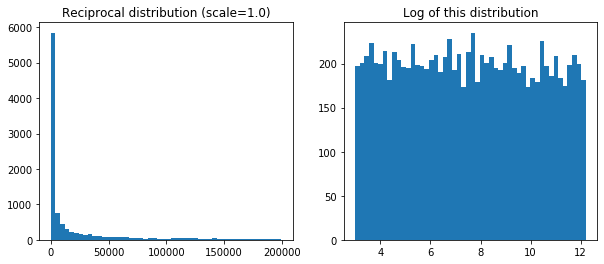

In [105]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

In [109]:
reciprocal.rvs(1, 60, size=10)

array([12.32379107,  5.14504296,  2.28831368,  1.54222196, 35.55252262,
        1.35607256,  3.45956426,  3.46979836, 29.54141662, 47.98834729])

In [110]:
reciprocal.rvs(1,1.1 ,size=10)

array([1.08354708, 1.02520886, 1.01937454, 1.01857279, 1.0796876 ,
       1.065143  , 1.08799844, 1.06297475, 1.08881207, 1.08896417])

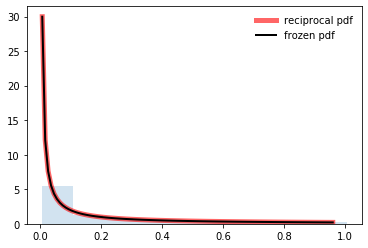

In [117]:
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = 0.00623, 1.01

mean, var, skew, kurt = reciprocal.stats(a, b, moments='mvsk')

x = np.linspace(reciprocal.ppf(0.01, a, b),
                reciprocal.ppf(0.99, a, b), 100)
ax.plot(x, reciprocal.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='reciprocal pdf')

rv = reciprocal(a, b)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

r = reciprocal.rvs(a, b, size=1000)

ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()

In [122]:
vals = reciprocal.ppf([0.001, 0.5, 0.999], a, b)
np.allclose([0.001, 0.5, 0.999], reciprocal.cdf(vals, a, b))

True

In [119]:
vals

array([0.00626178, 0.07932402, 1.00487384])

In [120]:
np.allclose

<function numpy.allclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)>

In [ ]:
#Exercise 3

In [123]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [132]:
'''
Note: this feature selector assumes that you have already computed 
the feature importances somehow (for example using a RandomForestRegressor). 
You may be tempted to compute them directly in the TopFeatureSelector's fit() method, 
however this would likely slow down grid/randomized search since the feature 
importances would have to be computed for every hyperparameter combination 
(unless you implement some sort of cache).
'''

"\nNote: this feature selector assumes that you have already computed \nthe feature importances somehow (for example using a RandomForestRegressor). \nYou may be tempted to compute them directly in the TopFeatureSelector's fit() method, \nhowever this would likely slow down grid/randomized search since the feature \nimportances would have to be computed for every hyperparameter combination \n(unless you implement some sort of cache).\n"

In [125]:
k=5

In [126]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [130]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  7,  9, 10, 12])

In [127]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [128]:
housing_prepared_top_k_features[0:k]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ],
       [-0.01706767, -1.04556555,  0.08973561, -0.19645314,  1.        ],
       [ 0.49247384, -0.44143679, -0.00419445,  0.2699277 ,  0.        ]])

In [131]:
housing_prepared[0:k, top_k_feature_indices]

array([[-1.15604281, -0.61493744, -0.08649871,  0.15531753,  0.        ],
       [-1.17602483,  1.33645936, -0.03353391, -0.83628902,  0.        ],
       [ 1.18684903, -0.5320456 , -0.09240499,  0.4222004 ,  0.        ],
       [-0.01706767, -1.04556555,  0.08973561, -0.19645314,  1.        ],
       [ 0.49247384, -0.44143679, -0.00419445,  0.2699277 ,  0.        ]])

In [ ]:
#Exercise 4

In [133]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)), #passes an array
        #whose indices match up to "attributes" array of features
    ('svm_reg', SVR(**rnd_search.best_params_)) #passes a dict
])

In [134]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

In [135]:
#Exercise 5

In [294]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  8.4min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed: 18.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                     

In [ ]:
grid_search_prep.best_params_

In [227]:
tx = np.array([3, 9 ,4, 2, 7 ,1 ,5 ,6 ,7])

In [290]:
tk = (-5 ,7)

In [291]:
tx[list(tk)]

array([7, 6])

In [292]:
ty = np.argpartition(tx, tk)
ty

array([3, 5, 0, 2, 6, 7, 4, 8, 1])

In [293]:
tx[list(ty)]

array([2, 1, 3, 4, 5, 6, 7, 7, 9])

In [159]:
np.sort(np.argpartition(np.array(tx), -k)[-k:])